Determine the Optimal Number of pulses as a function of signal intensity

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

# Load motiondeblur module and Dataset class
import libwallerlab.projects.motiondeblur as md
import libwallerlab.projects.motiondeblur.bluranalysis as analysis
from libwallerlab.utilities.io import Dataset, isDataset
from libwallerlab.utilities import noise

# Platform imports
import os, glob
from os.path import expanduser

# Debugging imports
import llops as yp
import matplotlib.pyplot as plt
import numpy as np

yp.config.setDefaultBackend('numpy')
yp.config.setDefaultDatatype('float32')

In [2]:
dnf = lambda gamma: 1.12 * gamma ** 0.64

In [7]:
# Roughly equal at 1.5
bg = 380
s0 = 4000
gamma = 3
s_coded = (s0 - bg) * gamma + bg
f = analysis.getOptimalDnf(gamma)
r = 3.85

print('Difference:')
print((s_coded - bg) / (f * ( np.sqrt(s_coded + r ** 2))))
print((s0 - bg) / np.sqrt(s0 + r ** 2))

Difference:
102.36712357979792
57.13146963041464


## Equation for Pulse Count

$$\frac{(s * \gamma) }{ 1.12 * {\gamma}^{0.64} * \sqrt{s * \gamma + r^2}}$$

## Derivative
https://www.wolframalpha.com/input/?i=d%2Fdx+(s+*+x)+%2F+(1.12+*+x+%5E+0.64+*+sqrt(s+*+x+%2B+r+%5E+2))

## Optimal Point
https://www.wolframalpha.com/input/?i=(s+(0.321429+r%5E2+%2B+0.321429+s+x+-+0.446429+s+x%5E1.))%2F(x%5E0.64+(r%5E2+%2B+s+x)%5E(3%2F2))+%3D+0

$$\gamma_{opt} \approx \frac{2.57143 * r ^ 2 }{s}$$

<IPython.core.display.Javascript object>


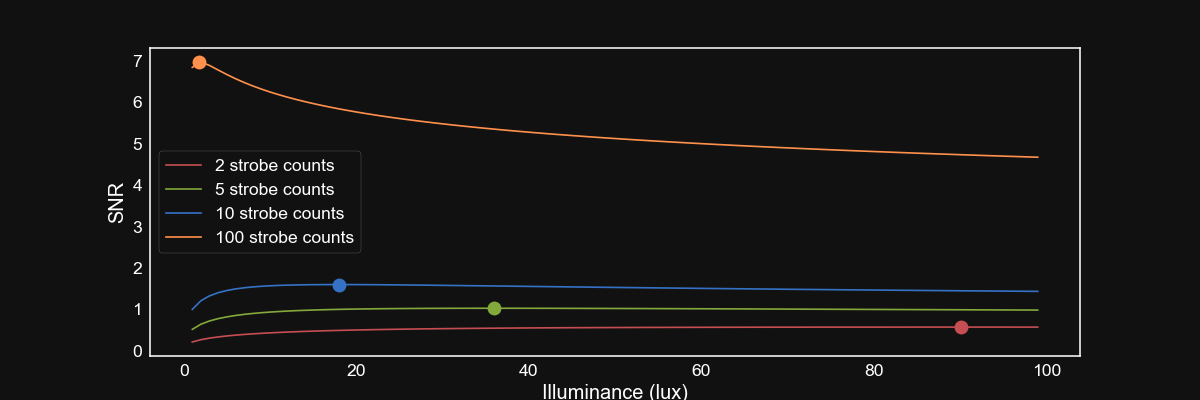

Text(0, 0.5, 'SNR')

In [123]:
def getOptimalPulseCount(signal_strobe, camera_readout_noise=3.85, camera_ad_conversion=0.46):
    """https://www.wolframalpha.com/input/?i=d%2Fdx+(s+*+x)+%2F+(1.12+*+x+%5E+0.64+*+sqrt(s+*+x+%2B+r+%5E+2))"""
    """https://www.wolframalpha.com/input/?i=(s+(0.321429+r%5E2+%2B+0.321429+s+x+-+0.446429+s+x%5E1.))%2F(x%5E0.64+(r%5E2+%2B+s+x)%5E(3%2F2))+%3D+0"""
    camera_readout_noise = camera_readout_noise / camera_ad_conversion
    return 2.57143 * camera_readout_noise ** 2 / signal_strobe

def snr(signal_strobe, pulse_count, r=8.37):
    signal = signal_strobe * pulse_count
    return signal / (dnf(pulse_count) * np.sqrt(signal + r ** 2))

mean_signals = [2, 5, 10, 100]
c = ['r', 'g', 'b', 'y', 'm']
plt.figure()
for index, mean_signal in enumerate(mean_signals):
    plt.plot(np.arange(100), [snr(mean_signal, pc) for pc in np.arange(100)], c=c[index], label='%d strobe counts' % mean_signal)
    plt.plot([getOptimalPulseCount(mean_signal)], [snr(mean_signal, getOptimalPulseCount(mean_signal))], '.', c=c[index], markersize=20)

plt.legend()
plt.xlabel('Illuminance (lux)')
plt.ylabel('SNR')

<IPython.core.display.Javascript object>


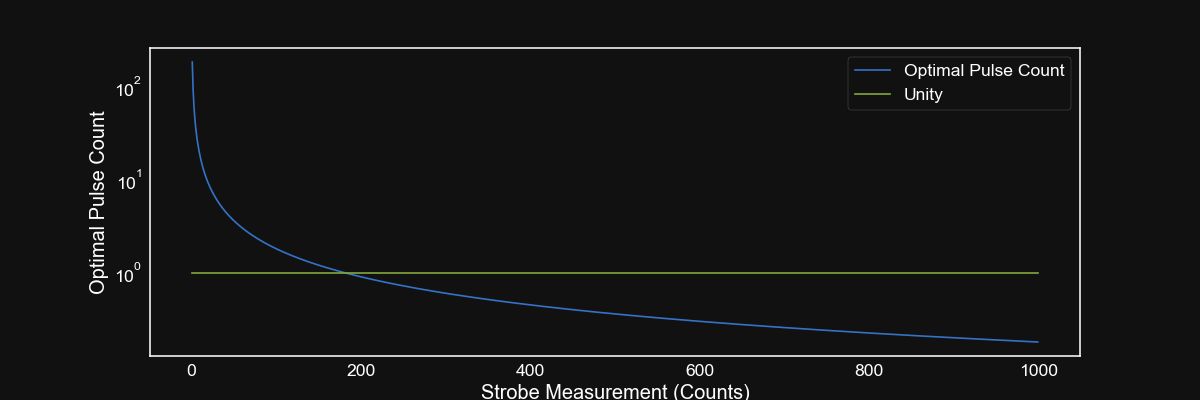

In [126]:
lux_range = np.arange(1, 1000)
plt.figure()
plt.semilogy(lux_range, [getOptimalPulseCount(lux) for lux in lux_range], label='Optimal Pulse Count')
plt.semilogy(lux_range, [1 for lux in lux_range], label='Unity')
plt.xlabel('Strobe Measurement (Counts)')
plt.ylabel('Optimal Pulse Count')
plt.legend()

## Relating Back To Relevent Parameters

<IPython.core.display.Javascript object>


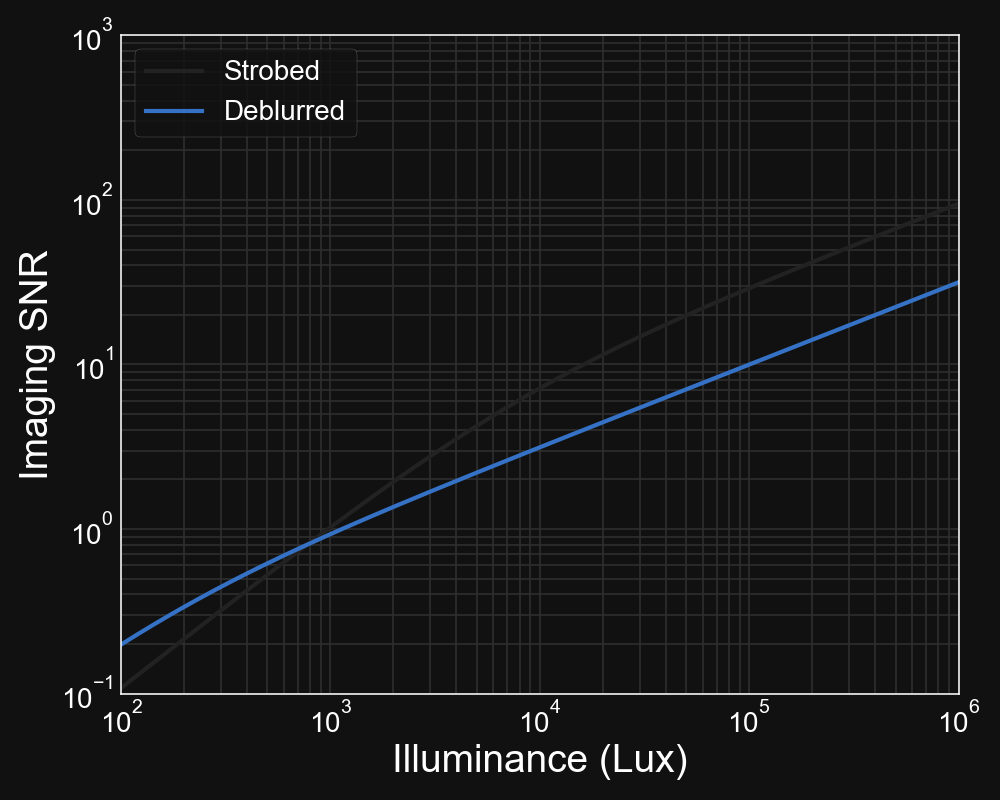

In [132]:
# Get system parameters
system_params = analysis.getDefaultSystemParams(camera_max_counts=1e8)

# Define which frame rates to use
illuminance_list = 10 ** np.arange(2, 7, 0.01)

# Initialize lists
snr_strobe_list, snr_coded_list = [], []
snr_strobe_list_noisy, snr_coded_list_noisy = [], []
snr_strobe_list_noiseless, snr_coded_list_noiseless = [], []

# Measurements: 11 Hz
frame_rate = 11

for index, illuminance in enumerate(illuminance_list):
    
    # Set illuminance
    system_params['illuminance'] = illuminance
    
    # Calculate source illuminance
    photon_pixel_rate = analysis.illuminanceToPhotonPixelRate(**system_params)
    
    # Strobed
    t_strobe, dnf_strobe = analysis.frameRateToExposure(frame_rate, photon_pixel_rate, 'strobe', **system_params)
    snr_strobe = analysis.exposureTimeToSnr(t_strobe, dnf=dnf_strobe, **system_params)
    snr_strobe_list.append(snr_strobe)
    
    # Coded
    t_coded, dnf_coded = analysis.frameRateToExposure(frame_rate, photon_pixel_rate, 'coded', **system_params)
    snr_coded = analysis.exposureTimeToSnr(t_coded, dnf=dnf_coded, **system_params)
    snr_coded_list.append(snr_coded)
    
# Perform plotting
lw = 3
plt.figure(figsize=(10, 8))

# Relevent Prediction
plt.loglog(illuminance_list, snr_strobe_list, 'k-', linewidth=lw, label='Strobed')
plt.loglog(illuminance_list, snr_coded_list, 'b-', linewidth=lw, label='Deblurred')

# Configure figure
plt.legend(fontsize=20, loc='upper left')
plt.xlabel('Illuminance (Lux)', fontsize=28)
plt.ylabel('Imaging SNR', fontsize=28)
plt.ylim((1e-1, 1e3))
plt.xlim((1e2, 1e6))
plt.grid('on', which='both')

# Set up ticks
ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
    
# # Add error bars
# q = ax.errorbar([illum_beads], [snr_strobed_beads], yerr=[[snr_strobed_error_beads, 10]], xerr=[0],
#             fmt='o', ecolor='b', capthick=2)
# Save
plt.tight_layout()


In [ ]:
analysis.